In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time,random
import numpy as np
import scipy.stats as scistats
import stabilityUtils as su
from scipy import stats
from tqdm import tqdm
DEFAULT_R2 = 0.36
DEFAULT_SLOPE = 0.048

In [2]:
def analyze_entropy_stability(entropy_values: np.ndarray, 
                               max_angle_deg: float = 0.048, 
                               min_r2: float = 0.36,window_size=150):
    if len(entropy_values) < 2:
        return False, float(0), float(0)
    
    x = np.arange(len(entropy_values))
    y = np.array(entropy_values)
    slope, intercept, r_value, _, _ = stats.linregress(x[-window_size:], y[-window_size:])
    r2 = r_value ** 2

    slope_angle_deg = np.degrees(np.arctan(slope))

    slope_check_passed = abs(slope_angle_deg) <= max_angle_deg
    r2_check_passed = r2 >= min_r2
    stable = bool(slope_check_passed and r2_check_passed)
    
    return stable,float(slope_angle_deg),float(r2)

In [3]:
def compute_binned_entropy(measurements, bin_resolution_ms: float = 0.0005) -> float:
    if len(measurements) == 0:
        return 0.0
    epsilon = bin_resolution_ms * 2.0
    binned_keys = np.round(measurements / epsilon) * epsilon
    unique_bins, counts = np.unique(binned_keys, return_counts=True)
    total_samples = len(measurements)
    probabilities = counts / total_samples
    entropy = -np.sum(probabilities * np.log2(probabilities))
    
    return entropy

In [4]:
def compute_entropy_stable(row,batch_entropy_size=2,batch_linear_size=50):
    nb_repetitions = row.repetitions
    
    entropies = []
    r2s = []
    stables = []
    slopes = []
    count = 1
    for i in range(batch_entropy_size,nb_repetitions,batch_entropy_size):
        entropies.append(compute_binned_entropy(row.repetitions_duration[:i]))
        if i >= (batch_linear_size*count):
            stable, slope, r2 = analyze_entropy_stability(entropies)
            stables.append(stable)
            r2s.append(r2)
            slopes.append(slope)
            count+=1
    
    return entropies[-1],r2s[-1],stables[-1],slopes[-1]

In [5]:
def compute_entropy_graph(row,batch_entropy_size=2,batch_linear_size=50):
    nb_repetitions = row.repetitions
    
    entropies = []
    r2s = []
    stables = []
    slopes = []
    for i in range(batch_entropy_size,nb_repetitions,batch_entropy_size):
        entropies.append(compute_binned_entropy(row.repetitions_duration[:i]))
        if i % batch_linear_size == 0:
            stable, slope, r2 = analyze_entropy_stability(entropies)
            stables.append(stable)
            r2s.append(r2)
            slopes.append(slope)
    
    return entropies,r2s,stables,slopes

In [6]:
def compute_entropy_criterion(dataframe,batch_entropy_size=2,batch_linear_size=5):
    df_e = []
    df_e = dataframe.copy()
   
    df_e['slope'] = None
    df_e['r2'] = None
    df_e['entropy'] = None
    df_e['stable_entropy'] = None
    df_e['batch_entropy'] = batch_entropy_size
    df_e['batch_linear'] = batch_linear_size

    for idx in tqdm(df_e.index):
        entropies,r2s,stables,slopes = compute_entropy_graph(df_e.loc[idx],batch_entropy_size=batch_entropy_size,batch_linear_size=batch_linear_size)
        df_e.at[idx,'slope'] = slopes
        df_e.at[idx,'r2'] = r2s
        df_e.at[idx,'entropy'] = entropies
        df_e.at[idx,'stable_entropy'] = stables
        df_e
    return df_e

In [7]:
def compute_entropy_choice(dataframe,batch_entropy_size=2,batch_linear_size=5):
    df_e = []
    df_e = dataframe.copy()
   
    df_e['slope'] = None
    df_e['r2'] = None
    df_e['entropy'] = None
    df_e['stable_entropy'] = None

    for idx in tqdm(df_e.index):
        entropy,r2,stable,slope = compute_entropy_stable(df_e.loc[idx],batch_entropy_size=batch_entropy_size,batch_linear_size=batch_linear_size)
        df_e.at[idx,'slope'] = slope
        df_e.at[idx,'r2'] = r2
        df_e.at[idx,'entropy'] = entropy
        df_e.at[idx,'stable_entropy'] = stable
    return df_e


In [8]:
# EXPERIMENTS_10_31_2025 = "../src/build/csv/experiment-31-10-2025.csv"
# DF_EXPERIMENT_PICKLE = "./experiment-03-11.df.pickle"
# df_experiment_boostraped = su.load_or_compute(DF_EXPERIMENT_PICKLE,su.load_n_compute_dataframe,EXPERIMENTS_10_31_2025)
# df_exp_boot_entropy = compute_entropy_choice(df_experiment_boostraped)

In [9]:
EXPERIMENT_ORIGINAL_VS_BLOCKING_FILE = "../src/build/csv/originalvsblockingvsnoflush_small.csv"
df_now = su.load_experiment(EXPERIMENT_ORIGINAL_VS_BLOCKING_FILE)
df_now_w5 = df_now[df_now["warmups"]==5].copy()
df_now_w5 = df_now_w5.sort_values(by='repetitions')
df_now_boot = su.load_n_compute_dataframe(dataframe=df_now_w5)

100%|██████████| 30/30 [00:02<00:00, 14.47it/s] 


In [10]:
df_now_boot_entr = compute_entropy_choice(df_now_boot)

100%|██████████| 30/30 [00:00<00:00, 51.40it/s] 


In [11]:
def plot_evolution_thing(dataframe,x,stable,line_val=None,min=None):
    plt.plot(dataframe["repetitions"], dataframe[x], color='black')          # continuous line
    plt.scatter(dataframe["repetitions"], dataframe[x], c=np.where(dataframe[stable], 'green', 'blue'))  # markers colored by stable
    if line_val:
        plt.axhline(y=line_val, color='red', linestyle='--', label=f"{x}-min")
        if min == True:
            plt.fill_between(dataframe["repetitions"], -1, line_val, color='green', alpha=0.2)
        elif min == False:
            plt.fill_between(dataframe["repetitions"], line_val, max(dataframe[x] + [line_val])*1.1, color='green', alpha=0.2)
    
    plt.xlabel("nbr of repetitions")
    plt.ylabel(x)
    plt.title(f"Evolution of {x}")


In [12]:
def plot_things_single_version(dataframe,version="ReferenceBilateral",work_size=1):
    dataframe = dataframe[dataframe["version"]==version]
    dataframe = dataframe[dataframe["warmups"]==5]
    #dataframe = dataframe[dataframe["blocking"]==0]
    #dataframe = dataframe[dataframe["work_size"]==work_size]
    #dataframe = dataframe[dataframe["flush_l2"]==1]
    fig, axs = plt.subplots(1, 3, figsize=(10, 3), constrained_layout=True)
    plt.sca(axs[0])             
    plot_evolution_thing(dataframe,"entropy","stable_entropy")
    plt.sca(axs[1])             
    plot_evolution_thing(dataframe,"r2","stable_entropy",DEFAULT_R2,min=False)
    plt.sca(axs[2])             
    plot_evolution_thing(dataframe,"slope","stable_entropy",DEFAULT_SLOPE,min=True)
    
    fig.suptitle(f" Kernel {version}, work_size {work_size}", fontsize=16)

    return fig

In [13]:
df_now_boot_entr = compute_entropy_criterion(df_now_boot)

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:00<00:00, 77.98it/s] 


In [14]:
df_now_boot_entr

,memcpy2D,memcpy2H,warmup_duration,repetitions_duration,warmups,repetitions,kernel,version,ci_low,ci_high,ci_level,boostrap_data,std_error,slope,r2,entropy,stable_entropy,batch_entropy,batch_linear
3,0.292864,0.184320,"[0.259072, 0.176128, 0.171008, 0.172032, 0.172...","[0.17408, 0.17408, 0.172032, 0.173056, 0.17305...",5,10,Bilateral,NoFlushBilateral,0.000793,0.001311,0.9,"[0.0009660396679226068, 0.0007997695668128516,...",0.000165,[],[],"[-0.0, 1.5, 1.584962500721156, 1.9056390622295...",[],2,5
4,0.293888,0.185344,"[0.26112, 0.17408, 0.172032, 0.173056, 0.17408]","[0.173056, 0.17408, 0.177152, 0.175104, 0.1740...",5,10,Bilateral,OriginalBilateral,0.001003,0.002051,0.9,"[0.0011630404292199007, 0.0012952689296049755,...",0.000298,[],[],"[1.0, 2.0, 1.9182958340544893, 2.25]",[],2,5
5,0.296960,0.189440,"[0.262144, 0.172032, 0.173056, 0.172032, 0.173...","[0.176128, 0.175104, 0.175104, 0.172032, 0.177...",5,10,Bilateral,BlockingBilateral,0.000766,0.00202,0.9,"[0.0012116131395788052, 0.0018000277331196915,...",0.000381,[],[],"[1.0, 1.5, 1.9182958340544893, 1.75]",[],2,5
6,0.299008,0.186368,"[0.258048, 0.17408, 0.17408, 0.175104, 0.176128]","[0.177152, 0.172032, 0.173056, 0.172032, 0.174...",5,50,Bilateral,NoFlushBilateral,0.001615,0.002554,0.9,"[0.001394445887942597, 0.0019836019213541863, ...",0.000276,"[19.537319816693213, 6.579939007274104, 4.9461...","[0.8664343930423509, 0.533229595347314, 0.6616...","[1.0, 1.5, 2.2516291673878226, 2.1556390622295...","[False, False, False, False]",2,5
7,0.295936,0.183296,"[0.259072, 0.172032, 0.171008, 0.172032, 0.173...","[0.17408, 0.176128, 0.177152, 0.17408, 0.17305...",5,50,Bilateral,OriginalBilateral,0.001452,0.002008,0.9,"[0.0018111778373202379, 0.001583860228176718, ...",0.000166,"[16.68631370484072, 8.398156873723558, 4.96236...","[0.7507546528053383, 0.6955145029487142, 0.618...","[1.0, 1.5, 2.2516291673878226, 2.1556390622295...","[False, False, False, False]",2,5
8,0.295936,0.186368,"[0.26112, 0.171008, 0.172032, 0.17408, 0.172032]","[0.176128, 0.178176, 0.176128, 0.181248, 0.175...",5,50,Bilateral,BlockingBilateral,0.0019,0.002761,0.9,"[0.0018617660501792416, 0.0025016636461363067,...",0.00026,"[23.95967441282518, 11.49089334022672, 5.61767...","[0.9474313877263827, 0.7738146656809541, 0.535...","[1.0, 1.5, 2.2516291673878226, 2.5, 2.72192809...","[False, False, False, False]",2,5
9,0.295936,0.182272,"[0.26112, 0.172032, 0.176128, 0.178176, 0.169984]","[0.172032, 0.17408, 0.17408, 0.173056, 0.16896...",5,125,Bilateral,NoFlushBilateral,0.001709,0.0023,0.9,"[0.0020145658736472278, 0.0018141904877978002,...",0.000172,"[10.994896311064345, 7.257770510636251, 5.3113...","[0.6807519713412078, 0.8152264230797969, 0.830...","[1.0, 1.5, 1.9182958340544896, 1.75, 1.8464393...","[False, False, False, False, False, False, Fal...",2,5
10,0.294912,0.189440,"[0.262144, 0.169984, 0.171008, 0.169984, 0.173...","[0.173056, 0.175104, 0.173056, 0.173056, 0.177...",5,125,Bilateral,OriginalBilateral,0.001682,0.002043,0.9,"[0.0018921569423279913, 0.0019179429791565791,...",0.000109,"[22.9682854346865, 12.016412478059479, 7.06494...","[0.8287533217309545, 0.7891924067276131, 0.684...","[1.0, 0.8112781244591328, 1.7924812503605778, ...","[False, False, False, False, False, False, Fal...",2,5
11,0.294912,0.193536,"[0.260096, 0.172032, 0.173056, 0.17408, 0.173056]","[0.176128, 0.176128, 0.181248, 0.17408, 0.1761...",5,125,Bilateral,BlockingBilateral,0.001853,0.002277,0.9,"[0.0021626569694743586, 0.002267482856935421, ...",0.000125,"[26.10252189824947, 13.735620123026084, 8.9114...","[0.7859011458926389, 0.7668610463394382, 0.733...","[-0.0, 1.5, 1.4591479170272448, 2.155639062229...","[False, False, False, False, False, False, Fal...",2,5
14,0.296960,0.195584,"[0.264192, 0.176128, 0.175104, 0.173056, 0.173...","[0.177152, 0.17408, 0.175104, 0.17408, 0.17408...",5,250,Bilateral,BlockingBilateral,0.001597,0.001924,0.9,"[0.0017939404533974948, 0.0016720311496428559,...",0.000098,"[9.03829274130165, 6.58640481

In [15]:
def plot_evolution_entropy_graph(row,x,line_val=None,min=None,linear=False,stable="stable_entropy"):
    y = range(row["batch_entropy"],row["repetitions"],row["batch_entropy"])
    y_l = range(row["batch_entropy"]*row["batch_linear"],row["repetitions"],row["batch_entropy"]*row["batch_linear"])
    if linear:
        y = y_l
    plt.plot(y, row[x], color='black')
    true_indexes = np.where(row[stable])[0]
    if not linear:
        true_indexes = true_indexes * row["batch_linear"]
    if len(true_indexes) > 0:
        plt.scatter(np.array(y)[true_indexes], np.array(row[x])[true_indexes], c="green")
    if line_val:
        plt.axhline(y=line_val, color='red', linestyle='--', label=f"{x}-min")
        if min == True:
            plt.fill_between(y, -1, line_val, color='green', alpha=0.2)
        elif min == False:
            plt.fill_between(y, line_val, max(row[x] + [line_val])*1.1, color='green', alpha=0.2)
    
    plt.xlabel("nbr of repetitions")
    plt.ylabel(x)
    plt.title(f"Evolution of {x}")


In [16]:
def plot_all_evolution_graph(row):
    fig, axs = plt.subplots(1, 3, figsize=(10, 3), constrained_layout=True)
    plt.sca(axs[0])             
    plot_evolution_entropy_graph(row,"entropy",line_val=False,min=False,linear=False)
    plt.sca(axs[1])             
    plot_evolution_entropy_graph(row,"r2",line_val=DEFAULT_R2,min=False,linear=True)
    plt.sca(axs[2])             
    plot_evolution_entropy_graph(row,"slope",line_val=DEFAULT_SLOPE,min=True,linear=True)    
    fig.suptitle(f" Kernel {row["version"]}")

    return fig

In [ ]:
def my_stopping_vs_nvidia(dataframe_entr_boot,version="OriginalBilateral",repetitions=1500):
    dataframe = dataframe_entr_boot[dataframe_entr_boot["version"]==version]
    su.plot_compare_repetitions_multiple_version(dataframe)
    dataframe = dataframe[dataframe["repetitions"]==repetitions]
    row = dataframe.iloc[0]
    plot_all_evolution_graph(row)
    

: 

In [ ]:
my_stopping_vs_nvidia(df_now_boot_entr)

In [ ]:
# for wz in df_exp_boot_entropy["work_size"].unique():
#     plot_things_single_version(df_exp_boot_entropy,work_size=wz)

In [ ]:
# df_exp_boot_entropy["warmups"].unique()

In [ ]:
# dataframe = df_exp_boot_entropy[df_exp_boot_entropy["blocking"]==0]
# dataframe = dataframe[dataframe["work_size"]==1]
# dataframe = dataframe[dataframe["flush_l2"]==1]
# dataframe = dataframe[dataframe["warmups"]==5]
# dataframe = dataframe[dataframe["version"]=="ReferenceBilateral"]
# f = su.plot_compare_repetitions_multiple_version(dataframe,warmup=5)

In [ ]:
# su.plot_all_single_kernel_multiple_rep(dataframe)

In [ ]:
EXPERIMENTS_04_11_2025 = "../src/build/csv/experiment-04-11-2025.csv"
DF_EXPERIMENT_PICKLE_04_11 = "./experiment-04-11-2025.df.pickle"
df_04_boot = su.load_or_compute(DF_EXPERIMENT_PICKLE_04_11,su.load_n_compute_dataframe,EXPERIMENTS_04_11_2025)
df_04_boot_entr = compute_entropy_criterion(df_04_boot)

100%|██████████| 32/32 [00:00<00:00, 40.22it/s]


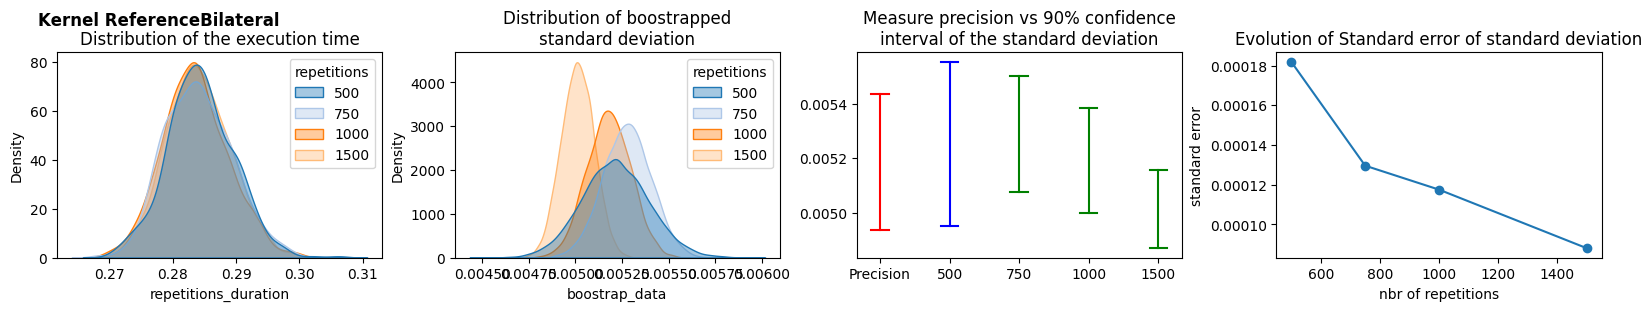

In [ ]:
dataframe = df_04_boot_entr[df_04_boot_entr["blocking"]==0]
dataframe = dataframe[dataframe["work_size"]==1]
dataframe = dataframe[dataframe["flush_l2"]==0]
dataframe = dataframe[dataframe["warmups"]==5]
dataframe = dataframe[dataframe["version"]=="ReferenceBilateral"]
f = su.plot_compare_repetitions_multiple_version(dataframe,warmup=5)

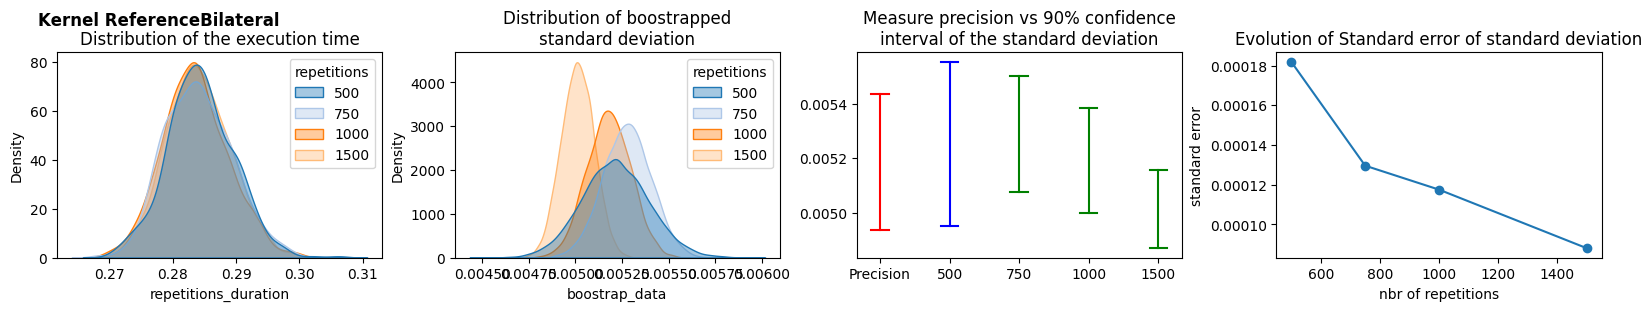

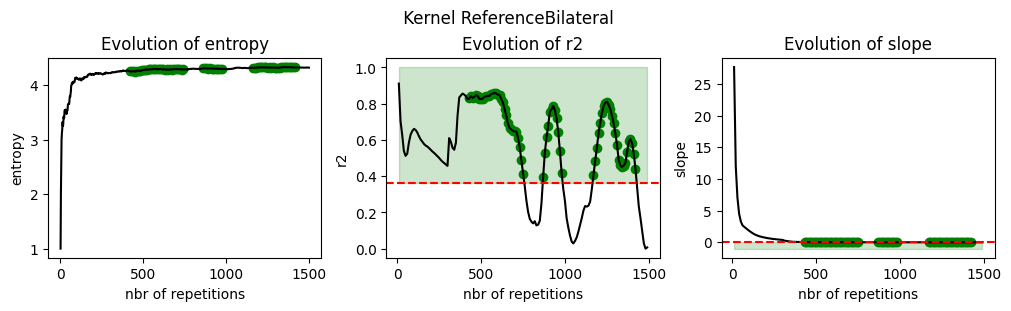

In [ ]:
my_stopping_vs_nvidia(dataframe,version="ReferenceBilateral",repetitions=1500)